In [1]:
#Setting working path required for relative package loading

import os
os.chdir("/home/tales/ds/walmart-recruiting-store-sales-forecasting/")
print("working dir:", "\'" + os.getcwd() + "\'")

working dir: '/home/tales/ds/walmart-recruiting-store-sales-forecasting'


In [2]:
import pandas as pd

from src.data import dao
from src.processment import process
from src.utils import pretties, time_utils, stats
from src.visualization import plot
from bokeh.plotting import show, output_notebook

In [3]:
pretties.max_data_frame_columns()
pretties.decimal_notation()
output_notebook()

Loading BokehJS ...

# <font color="darkred">Relations</font>
with target variable

# walmart-recruiting-store-sales-forecasting
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting

In [4]:
train = dao.load_dataset("train")
train = train.groupby("store_dept").apply(process.train_sales_semantic_enrichment)

feat = dao.load_features()
feat = process.features_semantic_enrichment(feat)

stores = dao.load_stores()

In [5]:
train = train.merge(feat, how="left", left_on=["Store", "Date"], right_on=["Store", "Date"], suffixes=["", "_y"])
del train["IsHoliday_y"]
del train["timestamp_y"]
train = train.merge(stores, how="left", left_on=["Store"], right_on=["Store"])

In [6]:
cols = ['Date', 'Store', 'Dept', 'Weekly_Sales', 'pre_holiday', 'IsHoliday', 'pos_holiday', 'Fuel_Price', 
        'CPI', 'Unemployment', 'celsius', 'datetime', 'Type', 'sales_diff', 'sales_diff_p',
        'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 
        'Size', 'Temperature', 'timestamp', 'store_dept', "day_n", "week_n", "month_n", "up_diff", "celsius_diff"]

In [7]:
train = train[cols].sort_values("timestamp")

In [8]:
train.sample(6)

,Date,Store,Dept,Weekly_Sales,pre_holiday,IsHoliday,pos_holiday,Fuel_Price,CPI,Unemployment,celsius,datetime,Type,sales_diff,sales_diff_p,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,timestamp,store_dept,day_n,week_n,month_n,up_diff,celsius_diff
51780,2010-06-04,29,85,2170.77,False,False,False,2.86,132.36,10.16,20.83,2010-06-04,B,249.99,0.13,nan,nan,nan,nan,nan,93638,69.49,1275620400.00,29_85,4,1,06,True,2.14
155978,2011-02-11,21,11,10636.82,False,True,False,3.02,212.59,8.03,1.45,2011-02-11,B,-5593.76,-0.34,nan,nan,nan,nan,nan,140167,34.61,1297393200.00,21_11,11,2,02,False,-0.96
140371,2010-12-31,12,18,11470.80,False,True,False,3.15,127.09,14.31,7.58,2010-12-31,B,-15774.63,-0.58,nan,nan,nan,nan,nan,112238,45.64,1293764400.00,12_18,31,4,12,False,-3.54
385988,2012-08-03,39,14,23962.46,False,False,False,3.42,220.63,6.62,28.92,2012-08-03,A,3319.25,0.16,25778.96,173.20,51.52,24900.66,4573.34,184109,84.05,1343962800.00,39_14,3,1,08,True,0.64
69722,2010-07-16,31,5,16350.22,False,False,False,2.62,210.76,8.10,29.78,2010-07-16,A,-1171.40,-0.07,nan,nan,nan,nan,nan,203750,85.61,1279249200.00,31_5,16,3,07,False,2.19
98053,2010-09-24,35,95,38533.72,False,False,False,2.71,136.63,8.86,19.49,2010-09-24,B,-3709.02,-0.09,nan,nan,nan,nan,nan,103681,67.08,1285297200.00,35_95,24,4,09,False,1.43


# <font color="navy">Date</font>

In [9]:
grouped_sales = train.groupby("Date")["Weekly_Sales"].median()
p = plot.plot_time_series_count(grouped_sales.index, grouped_sales, color="navy", title="Weekly_Sales vs Datetime", relative_y_axis=True, height=200)
show(p)

/home/tales/anaconda3/lib/python3.7/site-packages/bokeh/plotting/helpers.py:628: UserWarning: WheelZoomTool are being repeated
  warnings.warn("%s are being repeated" % ",".join(repeated_tools))


In [37]:
train["Date"].head(1).append(train["Date"].tail(1))

0         2010-02-05
421569    2012-10-26
Name: Date, dtype: object

In [10]:
# grouped_sales = train.groupby("Date")["sales_diff_p"].median()
# p = plot.plot_time_series_count(grouped_sales.index, grouped_sales, color="navy", title="sales_diff_p vs Datetime", relative_y_axis=True, height=200)
# show(p)

In [11]:
p = plot.plot_error_values(train, "week_n", "Weekly_Sales", drop_quantile=0.20, 
                           title="Weekly_Sales errors grouped by week_n")
show(p)

In [12]:
# p = plot.plot_error_values(train, "week_n", "sales_diff_p", drop_quantile=0.15, 
#                            title="Weekly_Sales errors grouped by week_n")
# show(p)

In [13]:
train["wm_date"] = train["month_n"] + "/" + train["week_n"].astype(str)

In [14]:
p = plot.plot_error_values(train, "wm_date", "Weekly_Sales", drop_quantile=0.25, 
                           title="Weekly_Sales errors grouped by wm_date", width=1200)
show(p)

In [15]:
# p = plot.plot_error_values(train, "wm_date", "sales_diff_p", drop_quantile=0.25, 
#                            title="sales_diff_p errors grouped by wm_date", width=1200)
# show(p)

# <font color="navy">Store</font>

In [16]:
train.groupby("Store")["Weekly_Sales"].mean().sort_values().plot.bar(title="Sales amout per store", figsize=(10, 3))

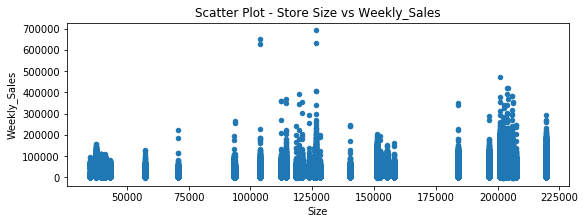

In [17]:
train.plot.scatter("Size", "Weekly_Sales", title="Scatter Plot - Store Size vs Weekly_Sales",figsize=(9,3))

# <font color="navy">IsHoliday</font>
holiday evaluation weight = 5 <br>
not holiday evaluation weight = 1

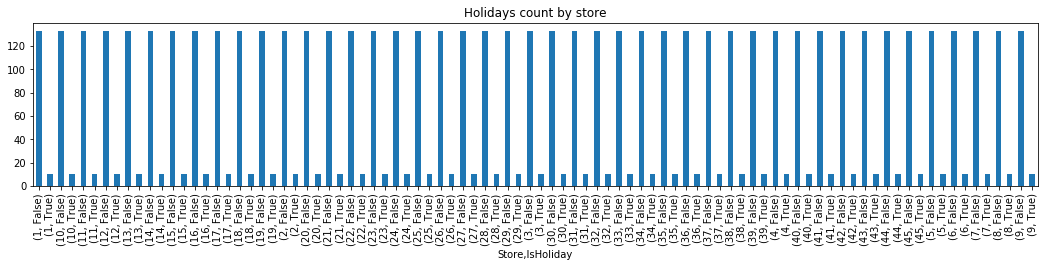

In [18]:
train.drop_duplicates(["Store", "Date"]).groupby("Store")["IsHoliday"].value_counts().plot.bar(title="Holidays count by store",figsize=(18,3))

In [19]:
stats.freq(train.drop_duplicates(["Store", "Date"])["IsHoliday"])

,freq_absolute,freq_relative
False,5985,93.01%
True,450,6.99%


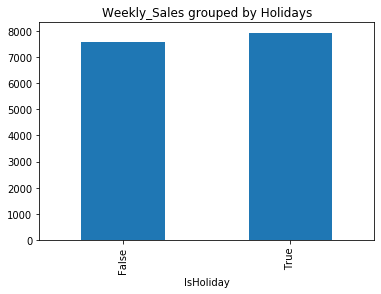

In [20]:
train.groupby("IsHoliday")["Weekly_Sales"].median().plot.bar(title="Weekly_Sales grouped by Holidays")

In [21]:
p = plot.plot_error_values(train, "IsHoliday", "Weekly_Sales", drop_quantile=0.25, 
                           title="Weekly_Sales errors grouped by IsHoliday")
show(p)

#### Before Holiday

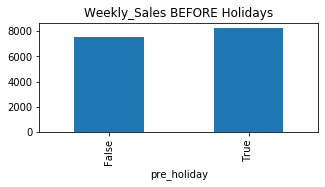

In [22]:
train.groupby("pre_holiday")["Weekly_Sales"].median().plot.bar(title="Weekly_Sales BEFORE Holidays", figsize=(5,2))

In [23]:
p = plot.plot_error_values(train, "pre_holiday", "Weekly_Sales", drop_quantile=0.25, 
                           title="Weekly_Sales errors grouped by pre_holiday", width=350, height=200)
show(p)

#### After Holiday

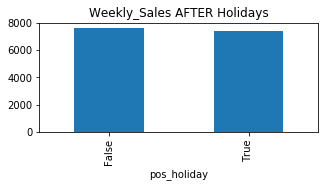

In [24]:
train.groupby("pos_holiday")["Weekly_Sales"].median().plot.bar(title="Weekly_Sales AFTER Holidays", figsize=(5,2))

In [25]:
p = plot.plot_error_values(train, "pos_holiday", "Weekly_Sales", drop_quantile=0.25, 
                           title="Weekly_Sales errors grouped by pos_holiday", width=350, height=200)
show(p)

# <font color="navy">Fuel_Price</font>

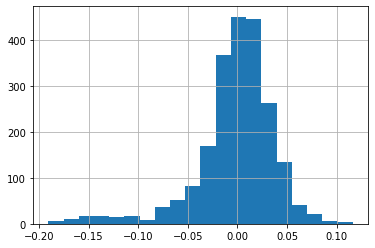

In [26]:
train.groupby(["Store", "wm_date"]).apply(lambda g : g["Fuel_Price"].corr(g["Weekly_Sales"])).hist(bins=20)

It seems that Fuel_Price variation for the same date over years is not strong related to Weekly_Sales variation

# <font color="navy">CPI</font>

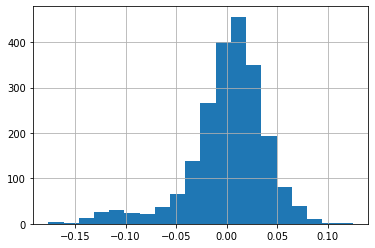

In [27]:
train.groupby(["Store", "wm_date"]).apply(lambda g : g["CPI"].corr(g["Weekly_Sales"])).hist(bins=20)

It seems that Fuel_Price variation for the same date over years is not strong related to Weekly_Sales variation

# <font color="navy">Unemployment</font>

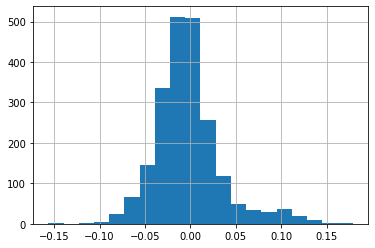

In [28]:
train.groupby(["Store", "wm_date"]).apply(lambda g : g["Unemployment"].corr(g["Weekly_Sales"])).hist(bins=20)

It seems that Fuel_Price variation for the same date over years is not strong related to Weekly_Sales variation

# <font color="navy">Temperature</font>

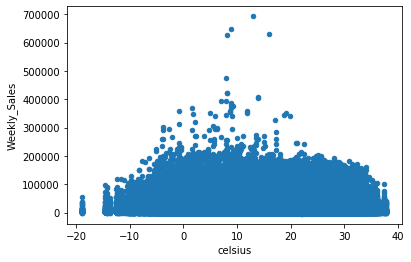

In [29]:
train.plot.scatter("celsius", "Weekly_Sales")

In [30]:
grouped_sales = train.groupby("Date")["celsius"].median()
p = plot.plot_time_series_count(grouped_sales.index, grouped_sales, color="magenta", title="Temperature vs Datetime", relative_y_axis=True, height=200)
show(p)

/home/tales/anaconda3/lib/python3.7/site-packages/bokeh/plotting/helpers.py:628: UserWarning: WheelZoomTool are being repeated
  warnings.warn("%s are being repeated" % ",".join(repeated_tools))


In [31]:
grouped_sales = train.groupby("Date")["Weekly_Sales"].median()
p = plot.plot_time_series_count(grouped_sales.index, grouped_sales, color="navy", title="Weekly_Sales vs Datetime", relative_y_axis=True, height=200)
show(p)

In [32]:
train["celsius"].corr(train["Weekly_Sales"])

-0.0023124470102593737

In [33]:
train["celsius_diff"].corr(train["Weekly_Sales"])

-0.0007430589483357949

# <font color="navy">Size</font>

0.8276068405388468


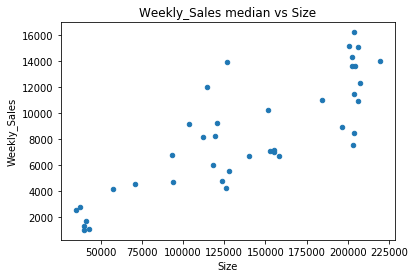

In [34]:
size_sales = train.groupby("Size")["Weekly_Sales"].median().reset_index()
print(size_sales["Size"].corr(size_sales["Weekly_Sales"]))
size_sales.plot.scatter("Size", "Weekly_Sales", title="Weekly_Sales median vs Size")

# <font color="navy">Markdown</font>

In [35]:
mds = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]

In [36]:
for md in mds:
    print(md+":", round(train[md].corr(train["Weekly_Sales"]), 4))

MarkDown1: 0.0853
MarkDown2: 0.0241
MarkDown3: 0.0604
MarkDown4: 0.0454
MarkDown5: 0.0904
